<a href="https://colab.research.google.com/github/kamalmukhalalaty/Data-Analytics/blob/main/Shopify_Data_Science_Internship_Challenge_Kamal_Mukhalalaty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fall 2021 Data Science Intern Challenge 

Please complete the following questions, and provide your thought process/work. You can attach your work in a text file, link, etc. on the application page. Please ensure answers are easily visible for reviewers!

## Question 1: 

Given some sample data, write a program to answer the following: click here to access the required data set:

(https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0)

On Shopify, we have exactly 100 sneaker shops, and each of these shops sells only one model of shoe. We want to do some analysis of the average order value (AOV). When we look at orders data over a 30 day window, we naively calculate an AOV of $3145.13. Given that we know these shops are selling sneakers, a relatively affordable item, something seems wrong with our analysis. 

>a. Think about what could be going wrong with our calculation. 

>b.  Think about a better way to evaluate this data. 

>c. What metric would you report for this dataset?

>d. What is its value?

### Data Loading, Transformation & Feature Engineeirng

In [ ]:
import pandas as pd
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/16i38oonuX1y1g7C_UAmiK9GkY7cS-64DfiDMNiR41LM/edit#gid=0')
sheet = wb.worksheet('Sheet1')
data = sheet.get_all_values()
df = pd.DataFrame(data)
#take first row as the column names
df.columns = df.iloc[0]
df = df.iloc[1:]
df.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
1,1,53,746,224,2,cash,2017-03-13 12:36:56
2,2,92,925,90,1,cash,2017-03-03 17:38:52
3,3,44,861,144,1,cash,2017-03-14 4:23:56
4,4,18,935,156,1,credit_card,2017-03-26 12:43:37
5,5,18,883,156,1,credit_card,2017-03-01 4:35:11


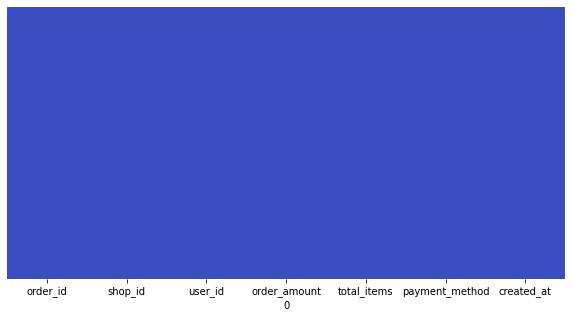

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Check for nans visualized using heatmap
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(df.isnull(), cmap='coolwarm', yticklabels=False, cbar=False, ax=ax)

Thank you for the clean data!

In [ ]:
# check data types
df.dtypes

0
order_id          object
shop_id           object
user_id           object
order_amount      object
total_items       object
payment_method    object
created_at        object
dtype: object

Will need to change data types to pull descriptive statistics 

In [ ]:
# convert just columns 'order_id':'order_amount' to numeric
inter=df.loc[:,'order_id':'total_items'].apply(pd.to_numeric)
df=pd.concat([inter, df.loc[:,'payment_method':]],axis=1)

I will create a feature for the actual price to help put the order_amount & total_items column values into context.

In [ ]:
df['price']=df.order_amount/df.total_items

### a. Think about what could be going wrong with our calculation.

Average Order Value (OVA) of $3145.13

In [ ]:
df.order_amount.describe()

count      5000.000000
mean       3145.128000
std       41282.539349
min          90.000000
25%         163.000000
50%         284.000000
75%         390.000000
max      704000.000000
Name: order_amount, dtype: float64

In [ ]:
df.dtypes

0
order_id            int64
shop_id             int64
user_id             int64
order_amount        int64
total_items         int64
payment_method     object
created_at         object
price             float64
dtype: object

Here we see a large dissconect between the mean and median (mean=3145.128 vs meadian(50%)=284) which indicates that we are dealing with a skewed distribution as shown in the histogram bellow.

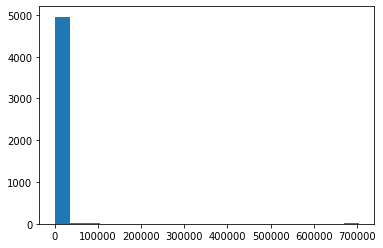

In [ ]:
plt.hist(df.order_amount, bins=20);

looking carefully we can see a small bar (fat tail) in the $700,000 region, this extreme outlier can skew the mean!

####**Conclusion:**
**Based on Summary Statistics:**

- The Mean is deceivingly very large and evidently skewed at **$3145.128** 
  - *The quoted AOV value is the mean of order amounts, given the skewed nature of the mean, it is clearly not the best metric to use here.*

- The Standard Deviation is larger than the mean itself at **$ 41,282** 
  - *Further supporting that the mean is not the best metric to use in this case*

- We see some massive outliers that have certainly skewed the Mean like the Max order value of **$704,000**


### b. Think about a better way to evaluate this data.

- One approach (The easy way out):
  - Based on my findings from part **a.** A more appropriate metric to use here would be the median of **$284.0**. Just as that would be a more fair metric to use when evaluating income, in both cases you have outliers skewing the mean.

  - However, even then **$284** intuitively seems too high for sneakers. 

- Alternatively (The right way):
  - Find the outliers, filter them out and use the mean of the filtered data.
  - according to our histogram the majority of the order values are in the $0-500 range. This could constitute retail buyers. a more useful statistic would be the mean of order values for just the retails buyers.
  - It is also evident that we have a fat tail that could be made up of commercial buyers. Describing this subset with its own mean could be of value if the amount of data is sufficient and diverse enough to be representative of the population yielding statistically significant & unbiased descriptive statistics.

**I will take on the alternative approach!**

#### Full Dataset

looking at the outliers

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


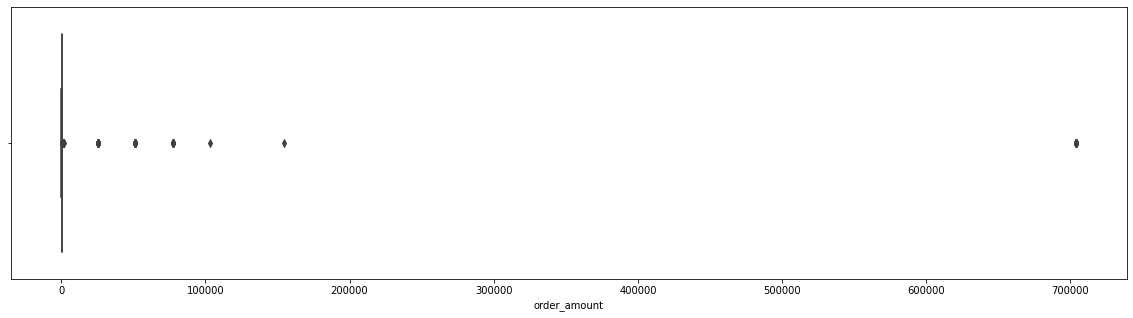

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(df.order_amount);

Thats a lot of outliers

**Zeroing in on the outliers**

In [ ]:
filter=df.sort_values(by='order_amount',ascending=False)
filter.groupby(['order_amount']).count().sort_values(by='order_amount',ascending=False).order_id[:15]

order_amount
704000    17
154350     1
102900     1
77175      9
51450     16
25725     19
1760       1
1408       2
1086       1
1064       1
1056       3
980        1
965        1
960        2
948        1
Name: order_id, dtype: int64

Here we see that there is a significant amount of large order values (our outliers) and they occur at high frequencies. For example: 
- **$704,000** order being placed 17 times

- **$51,450** order being placed 16 times

- **$25,725** order being placed 19 times


In this case the fact that these order values were each repeated over 16 seperate times within the span of a month, could indicate a routine bulk order. 

Due to the enormity of the gap between the 1,760 and 25,725 order values, I am tempted to draw a line between them and use the smaller order value distribution for my new average. 

However, the common statistical approach is to add (1.5 * the Inner Quartile Range (IQR)) to the upper and lower quartiles like follows:

- UPPER LIMIT= UPPER_QUARTILE + IQR*1.5
- LOWER LIMIT LOWER_QUARTILE - IQR*1.5

The Box Plots represent this information in a visual manner where the box represnets values within the IQR and the whiskers represnet the upper and lower limits. 

There is a caveat as explained bellow:

The whiskers extend to the lowest (highest) data points still within 1.5*Inner Quartile Range (IQR) of the lower (upper) quartile. So depending on where the data points are, the whiskers on both sides won't necessarily be of the same length.

For a better understanding of how the box plot works and outliers are defined please refer to the image and links below.

https://stackoverflow.com/questions/51694935/seaborns-boxplot-whiskers-meaning

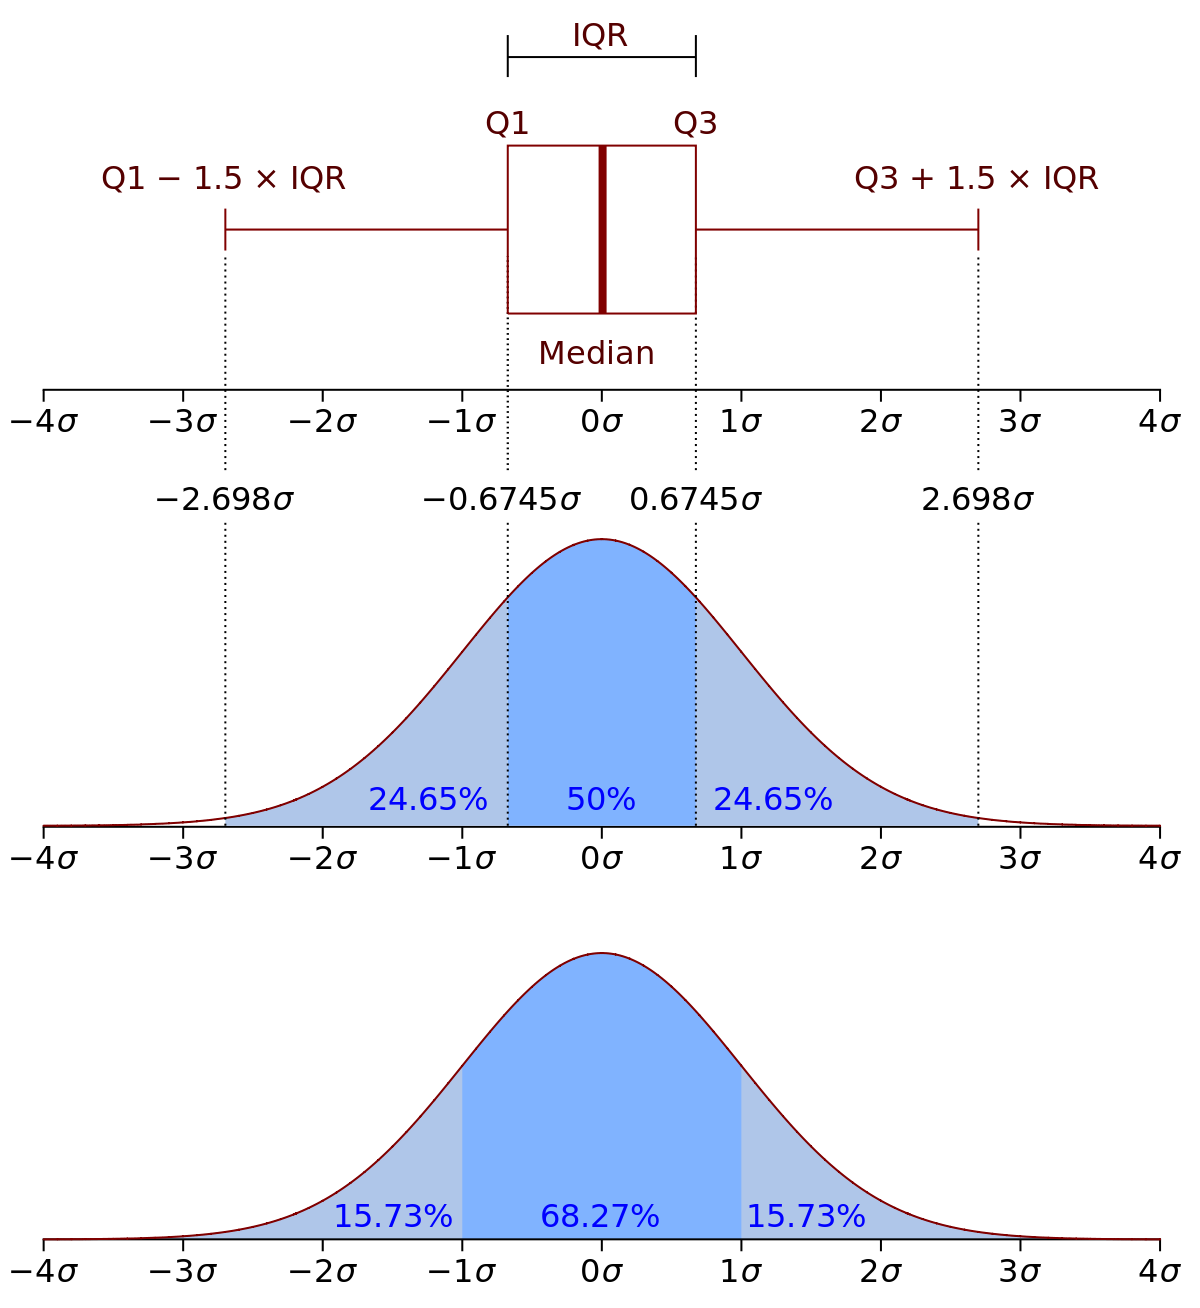

https://upload.wikimedia.org/wikipedia/commons/thumb/1/1a/Boxplot_vs_PDF.svg/500px-Boxplot_vs_PDF.svg.png


Now that we know what we are dealing with, lets filter the data!

#### Filtration Process

In [ ]:
# Compile Quartile and IQR Information
q1 = df.order_amount.quantile(0.25)
q3 =df.order_amount.quantile(0.75)
iqr = q3 - q1
limit_lower = q1 - 1.5*iqr
limit_upper = q3 + 1.5*iqr
print('Upper Limit=', limit_upper)
print('Lower Limit=', limit_lower)
# Filtering the data based on this
filtered_out=df[(df.order_amount <= limit_lower) | (df.order_amount >= limit_upper)]
filtered_in=df[(df.order_amount > limit_lower) & (df.order_amount < limit_upper)]

Upper Limit= 730.5
Lower Limit= -177.5


**$730** seems low for an upper limit. this may not be the best approach however I will follow through. 

#### Filtered Out Data (Suspected Commertial Buyers)

In [ ]:
filtered_out.order_amount.describe()

count       141.000000
mean     101407.638298
std      225491.524131
min         735.000000
25%         786.000000
50%        1056.000000
75%       51450.000000
max      704000.000000
Name: order_amount, dtype: float64

For starters, the mean is significantly higher at $$101,407 vs our mean over the full dataset of $3,145

Looking at the dataframe

In [ ]:
filtered_out.sort_values(by='order_amount', ascending=False)

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price
16,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
521,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
1563,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0
1363,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1603,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
...,...,...,...,...,...,...,...,...
3429,3429,11,922,736,4,cash,2017-03-04 21:14:40,184.0
1504,1504,11,904,736,4,debit,2017-03-06 23:08:25,184.0
3610,3610,11,901,736,4,debit,2017-03-08 2:21:55,184.0
3518,3518,11,732,736,4,debit,2017-03-20 8:36:02,184.0


Recall: 
- **$704,000** order placed 17 times

- **$51,450** order placed 16 times

- **$25,725** order placed 19 times

**zeroing in on the largest order value of $704,000**

In [ ]:
filtered_out[filtered_out.order_amount==704000]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price
16,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
61,61,42,607,704000,2000,credit_card,2017-03-04 4:00:00,352.0
521,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
1105,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
1363,1363,42,607,704000,2000,credit_card,2017-03-15 4:00:00,352.0
1437,1437,42,607,704000,2000,credit_card,2017-03-11 4:00:00,352.0
1563,1563,42,607,704000,2000,credit_card,2017-03-19 4:00:00,352.0
1603,1603,42,607,704000,2000,credit_card,2017-03-17 4:00:00,352.0
2154,2154,42,607,704000,2000,credit_card,2017-03-12 4:00:00,352.0
2298,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0


We note the following:

- same shop id
- same user id
- same total number of items and value
- same order time at 4AM and payment method
  - orders seem to be periodic
  - could be on an automated order trigger 
  - seems to be some duplicates as well (will be investigated next)

This is textbook commercial bulk ordering. The shoe itself is a little pricey at 704000/2000=$352 per pair. Especially when considering the fact that the commercial buyer will need to upsell the shoe to make a profit!

Looking at duplicated times 

In [ ]:
filtered_out.created_at.value_counts()

2017-03-28 4:00:00     3
2017-03-02 4:00:00     2
2017-03-07 4:00:00     2
2017-03-24 4:00:00     2
2017-03-27 9:27:20     1
                      ..
2017-03-17 22:32:21    1
2017-03-26 17:08:19    1
2017-03-25 4:00:00     1
2017-03-09 15:21:35    1
2017-03-12 23:00:22    1
Name: created_at, Length: 136, dtype: int64

looking at the top 4 repeats 

In [ ]:
filtered_out.created_at.value_counts()[:4].index.values

array(['2017-03-28 4:00:00', '2017-03-02 4:00:00', '2017-03-07 4:00:00',
       '2017-03-24 4:00:00'], dtype=object)

In [ ]:
filtered_out[filtered_out.created_at.isin(filtered_out.created_at.value_counts()[:4].index.values)]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price
16,16,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
521,521,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0
1105,1105,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
2298,2298,42,607,704000,2000,credit_card,2017-03-07 4:00:00,352.0
2836,2836,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
2970,2970,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
3333,3333,42,607,704000,2000,credit_card,2017-03-24 4:00:00,352.0
4057,4057,42,607,704000,2000,credit_card,2017-03-28 4:00:00,352.0
4647,4647,42,607,704000,2000,credit_card,2017-03-02 4:00:00,352.0


hard to tell if these are duplicates or real double orders. The fact that they are assigned unique order ID's makes it hard to decide

**Looking at the other high order amounts**

- **$51,450** order placed 16 times

- **$25,725** order placed 19 times

**$51,450** order placed 16 times

In [ ]:
filtered_out[filtered_out.order_amount==51450]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price
491,491,78,936,51450,2,debit,2017-03-26 17:08:19,25725.0
494,494,78,983,51450,2,cash,2017-03-16 21:39:35,25725.0
512,512,78,967,51450,2,cash,2017-03-09 7:23:14,25725.0
618,618,78,760,51450,2,cash,2017-03-18 11:18:42,25725.0
1530,1530,78,810,51450,2,cash,2017-03-29 7:12:01,25725.0
2453,2453,78,709,51450,2,cash,2017-03-27 11:04:04,25725.0
2496,2496,78,707,51450,2,cash,2017-03-26 4:38:52,25725.0
2513,2513,78,935,51450,2,debit,2017-03-18 18:57:13,25725.0
2819,2819,78,869,51450,2,debit,2017-03-17 6:25:51,25725.0
2822,2822,78,814,51450,2,cash,2017-03-02 17:13:25,25725.0


**$25,725** order placed 19 times

In [ ]:
filtered_out[filtered_out.order_amount==25725]

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price
161,161,78,990,25725,1,credit_card,2017-03-12 5:56:57,25725.0
1057,1057,78,800,25725,1,debit,2017-03-15 10:16:45,25725.0
1194,1194,78,944,25725,1,debit,2017-03-16 16:38:26,25725.0
1205,1205,78,970,25725,1,credit_card,2017-03-17 22:32:21,25725.0
1385,1385,78,867,25725,1,cash,2017-03-17 16:38:06,25725.0
1420,1420,78,912,25725,1,cash,2017-03-30 12:23:43,25725.0
1453,1453,78,812,25725,1,credit_card,2017-03-17 18:09:54,25725.0
2271,2271,78,855,25725,1,credit_card,2017-03-14 23:58:22,25725.0
2549,2549,78,861,25725,1,cash,2017-03-17 19:36:00,25725.0
2774,2774,78,890,25725,1,cash,2017-03-26 10:36:43,25725.0


Now we understand that these are from the same shop! the only difference is the quantity! and since 1 unit costs **$24,725** it is definitely a bulk order!

**Lets create a table to analyse this further** 

Here the groups shop_id, order_amount	and total_items while showing the sum and count for each order_amount.

The table is sorted in descending order of order_amount

In [ ]:
intermediate=filtered_out.groupby(["shop_id",'order_amount','total_items','price'])['order_amount'].agg(['sum','count'])
#intermediate.sort_values(by='sum', ascending=False)[:20]
intermediate.sort_index(level=1,ascending=False)

sum  count
shop_id order_amount total_items price                   
42      704000       2000        352.0    11968000     17
78      154350       6           25725.0    154350      1
        102900       4           25725.0    102900      1
        77175        3           25725.0    694575      9
        51450        2           25725.0    823200     16
        25725        1           25725.0    488775     19
42      1760         5           352.0        1760      1
        1408         4           352.0        2816      2
43      1086         6           181.0        1086      1
54      1064         8           133.0        1064      1
42      1056         3           352.0        3168      3
89      980          5           196.0         980      1
50      965          5           193.0         965      1
91      960          6           160.0         960      1
13      960          6           160.0         960      1
61      948          6           158.0         948      1
51      935          5           187.0         935      1
6       935          5           187.0        1870      2
11      920          5           184.0         920      1
90      890          5           178.0         890      1
82      885          5           177.0         885      1
60      885          5           177.0         885      1
88      880          5           176.0         880      1
26      880          5           176.0        1760      2
70      865          5           173.0         865      1
33      865          5           173.0         865      1
27      845          5           169.0         845      1
46      830          5           166.0        2490      3
68      816          6           136.0         816      1
29      815          5           163.0         815      1
19      815          5           163.0         815      1
97      810          5           162.0         810      1
66      805          5           161.0        1610      2
12      804          4           201.0        1608      2
91      800          5           160.0        2400      3
61      790          5           158.0        1580      2
67      786          6           131.0         786      1
89      784          4           196.0        1568      2
99      780          4           195.0        1560      2
86      780          6           130.0         780      1
23      780          5           156.0         780      1
18      780          5           156.0        2340      3
16      780          5           156.0         780      1
83      774          6           129.0         774      1
50      772          4           193.0        1544      2
96      765          5           153.0        1530      2
84      765          5           153.0         765      1
74      765          5           153.0         765      1
15      765          5           153.0         765      1
38      760          4           190.0        3040      4
51      748          4           187.0        1496      2
6       748          4           187.0        2244      3
87      745          5           149.0        1490      2
10      740          5           148.0         740      1
11      736          4           184.0        2944      4
57      735          5           147.0         735      1

This table is very discriptive as it tells us which shops are recieving the largest value orders and overall revenue. From this it is evident that **store 42 & 78** appear to be **big comercial suppliers.**

scrolling down to the bottom of the list we still see high order_amoount and total_items values which are characteristic of comercial bulk ordering and good to filter out!

***which shops/customers are recieveing/spending the most money over the 30 day period***

In [ ]:
#shops
intermediate=filtered_out.groupby(['shop_id']).agg({'order_amount':'sum'})
intermediate.sort_values(by='order_amount',ascending=False)[:5]

,order_amount
shop_id,
42,11975744
78,2263800
6,4114
11,3864
91,3360


In [ ]:
#customers
intermediate=filtered_out.groupby(['user_id']).agg({'order_amount':'sum'})
intermediate.sort_values(by='order_amount',ascending=False)[:10]

,order_amount
user_id,
607,11968000
878,154350
834,102900
818,77990
915,77175
928,77175
817,77175
855,77175
787,77175


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


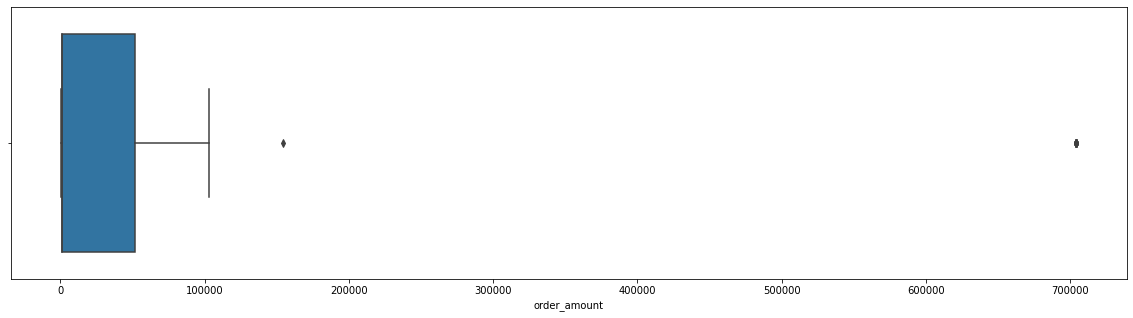

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(filtered_out.order_amount);

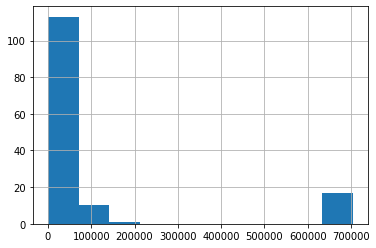

In [ ]:
filtered_out.order_amount.hist();

In [ ]:
filtered_out.order_amount.describe()

count       141.000000
mean     101407.638298
std      225491.524131
min         735.000000
25%         786.000000
50%        1056.000000
75%       51450.000000
max      704000.000000
Name: order_amount, dtype: float64

All in all, as a stand alone distribution, it is not a good one. with just 141 data points, a mean and median planets apart and extremly skewed distribution, it does not make sense to use pull and use descriptive statistics from this outlier or filtered out data. 

#### Filtered In Data (Suspected Retail Buyers)

**Looking at the filtered in data points**

In [ ]:
filtered_in

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at,price
1,1,53,746,224,2,cash,2017-03-13 12:36:56,112.0
2,2,92,925,90,1,cash,2017-03-03 17:38:52,90.0
3,3,44,861,144,1,cash,2017-03-14 4:23:56,144.0
4,4,18,935,156,1,credit_card,2017-03-26 12:43:37,156.0
5,5,18,883,156,1,credit_card,2017-03-01 4:35:11,156.0
...,...,...,...,...,...,...,...,...
4996,4996,73,993,330,2,debit,2017-03-30 13:47:17,165.0
4997,4997,48,789,234,2,cash,2017-03-16 20:36:16,117.0
4998,4998,56,867,351,3,cash,2017-03-19 5:42:42,117.0
4999,4999,60,825,354,2,credit_card,2017-03-16 14:51:18,177.0


In [ ]:
intermediate=filtered_in.groupby(["shop_id",'order_amount','total_items'])['order_amount'].agg(['sum','count'])
#intermediate.sort_values(by='sum', ascending=False)[:20]
intermediate.sort_index(level=1,ascending=False)

,,,sum,count
shop_id,order_amount,total_items,,
52,730,5,730,1
47,725,5,725,1
79,724,4,724,1
43,724,4,1448,2
90,712,4,4272,6
...,...,...,...,...
7,112,1,2576,23
100,111,1,1776,16
32,101,1,1515,15


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


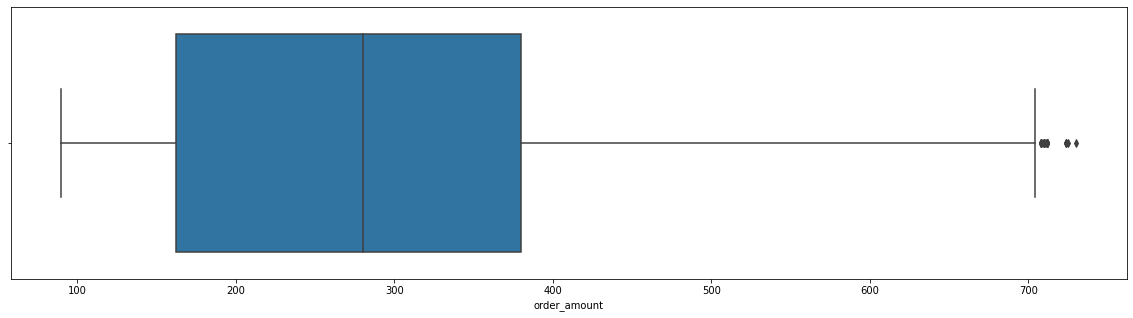

In [ ]:
plt.figure(figsize=(20,5))
sns.boxplot(filtered_in.order_amount);

This looks a lot more reasonable:
- we have some outliers just outside the $700 range

- our median is somewhere between $275<=>$300 which is close to the median of the unfiltered data set which was $284.

In [ ]:
filtered_in.order_amount.describe()

count    4859.000000
mean      293.715374
std       144.453395
min        90.000000
25%       162.000000
50%       280.000000
75%       380.000000
max       730.000000
Name: order_amount, dtype: float64

looking at our final summary statistics, we see some promising results.

- the mean was brought down from **$3,145.13 to 293.7** a large change caused by filtering out the outliers!

  - The standard deviation is also still high at approximately half the mean **$144** a great reduction from the alarming **41,282** standard deviation of the unfiltered data. 

- The median was brought down from **$284 to 280** which is surprisingly small! It seems my initial thought of just taking the median had some merit to it after all!

  - the distribution is still slightly skewed however the mean and median are only **$10** apart!

**Looking at a histogram of the filtered order_amount distribution**

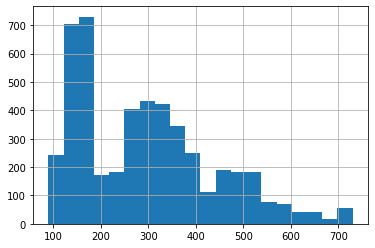

In [ ]:
filtered_in.order_amount.hist(bins=20);

looking at the distribution we see **three clear distributions and one not so clear distribution** of shoe order amounts:

- First and most populated distribution around $150 

- Second and less populated distribution around  $300 

- Third and least populated distribution around $500 range 

- Final fat tail which could constitute its distribution around the $700 mark

It is interesting to note the decrease in popularity as price increases. 

We must also note that these are overall order amounts and not shoe prices!

**As I have created a price column we can look at that distribution as well**

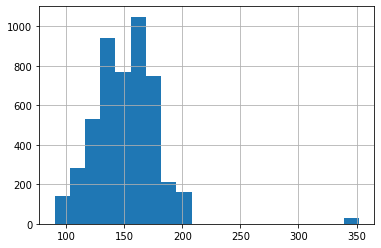

In [ ]:
filtered_in.price.hist(bins=20);

we see a somewhat normal distribution centered aroud 150 with outliers around 350

#### BONUS Hypothesis Test: Test for Statistcal Significance of the difference in means of the Old vs New (Filtered) Distributions

For our T-test:

$H_0$: No Significant difference between the means of the Unfiltered (OLD) vs filtered (NEW) distributions.<br>

$H_a$: There is a difference between the means of the Unfiltered (OLD) vs filtered (NEW) distributions.<br>

$\alpha$ = 5% (generic setting used)


##### Descriptive statistics:

mean = 3145.13, st. dev = 41278.4
number of Out samples N= 5000

                       Histogram of  OLD distribution


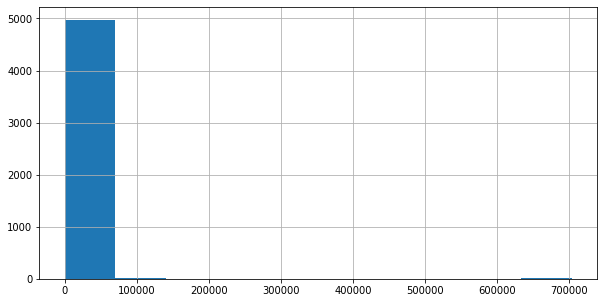

Due to the skewed nature of the distribution, it would make more sense to look at the median,

Median= 284.0
Mean= 3145.128

___________________________________________________________________________________________________

mean = 293.715, st. dev = 144.439
number of Out samples N= 4859

                       Histogram of NEW distribution


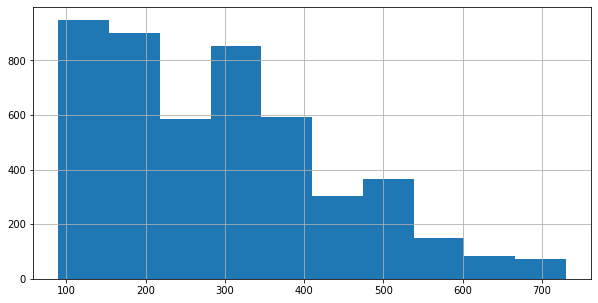

Due to the skewed nature of the distribution, it would make more sense to look at the median,

Median= 280.0
Mean= 293.7153735336489


In [ ]:
import numpy as np
from scipy import stats # important library

# As previously defined
NEW=filtered_in.order_amount
OLD=df.order_amount

# Compute basic one number summaries
m_mu, m_sigma = np.mean(OLD), np.std(OLD)
print ("mean = %G, st. dev = %g" % (m_mu, m_sigma))
m_N = len(OLD)
print ('number of Out samples N=',m_N)

# plot histograms to get a sense of distributions
plt.figure(1)
OLD.hist(bins=10, figsize=(10, 5))
print('\n                       Histogram of  OLD distribution')
plt.show()
print('Due to the skewed nature of the distribution, it would make more sense to look at the median,')
print('\nMedian=',OLD.median())
print('Mean=',OLD.mean())

print("\n___________________________________________________________________________________________________\n")

# Compute basic one number summaries
f_mu, f_sigma = np.mean(NEW), np.std(NEW)
print ("mean = %G, st. dev = %g" % (f_mu, f_sigma))
f_N = len(NEW)
print ('number of Out samples N=',f_N)

# plot histograms to get a sense of distributions
plt.figure(2)
NEW.hist(bins=10, figsize=(10, 5))
print('\n                       Histogram of NEW distribution')
plt.show()
print('Due to the skewed nature of the distribution, it would make more sense to look at the median,')
print('\nMedian=',NEW.median())
print('Mean=',NEW.mean())

**Observation:**

As previously mentioned both distributions are skewed therefore we can visually confirm non-normality however for further confluence a normality test will be conducted below

###### Normal test:

Scipy's normaltest returns a 2-tuple of the chi-squared statistic, and the associated p-value. Given the null hypothesis that x came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen.

Basically if the p-val is very small, it means it is unlikely that the data came from a normal distribution.

In [ ]:
#The following was partially adapted from:
#   -https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
from scipy.stats import normaltest

stat, p = normaltest(OLD)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('OLD Distribution looks Gaussian (fail to reject H0)')
else:
	print('OLD Distribution does not look Gaussian (reject H0)')
 
stat, p = normaltest(NEW)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('NEW distribution looks Gaussian (fail to reject H0)')
else:
	print('NEW distribution does not look Gaussian (reject H0)')

Statistics=10038.550, p=0.000
OLD Distribution does not look Gaussian (reject H0)
Statistics=357.184, p=0.000
NEW distribution does not look Gaussian (reject H0)


**Clearly both distributions are not Normal therefore for the A t-test is not appropriate at this stage, we must bootstrap the data to get normal distributions**

##### Bootstraping

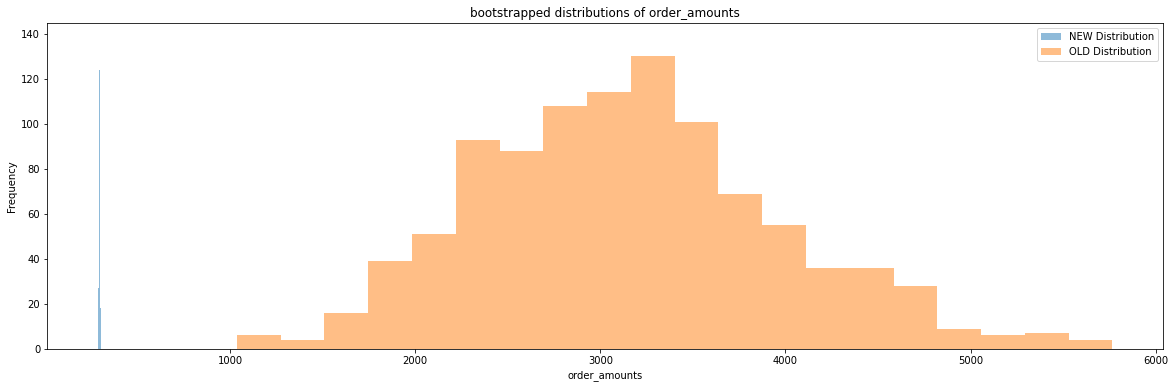

In [ ]:
#The following was partially adapted from: https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method
import matplotlib.pyplot as plt
from sklearn.utils import resample
from math import ceil
import math

num_iters=1000
num_samp_div=2

NEW_bs = []
OLD_bs =[]

for i in range(num_iters):
    OLD_avg= np.mean(resample(OLD, replace=True, n_samples=ceil(len(OLD)/num_samp_div), random_state=i))  #WAS THIS APPROPRIATE?
    OLD_bs.append(OLD_avg)

for j in range(num_iters):
    NEW_avg= np.mean(resample(NEW, replace=True, n_samples=ceil(len(NEW)/num_samp_div), random_state=j))   #WAS THIS APPROPRIATE?
    NEW_bs.append(NEW_avg)


b=20
plt.figure(figsize=(20, 6))
plt.hist(NEW_bs, bins = b,label = 'NEW Distribution', alpha = 0.5)
plt.hist(OLD_bs, bins = b,label = 'OLD Distribution', alpha = 0.5)
plt.legend()
plt.xlabel('order_amounts')
plt.ylabel('Frequency')
plt.title('bootstrapped distributions of order_amounts')
plt.show()

##### Normal Test:

Scipy's normaltest returns a 2-tuple of the chi-squared statistic, and the associated p-value. Given the null hypothesis that x came from a normal distribution, the p-value represents the probability that a chi-squared statistic that large (or larger) would be seen.

Basically if the p-val is very small, it means it is unlikely that the data came from a normal distribution.

In [ ]:
# Normal Test for Sanity Check 
from scipy.stats import normaltest

stat, p = normaltest(OLD_bs)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Bootstrapped OLD distribution looks Gaussian (fail to reject H0)')
else:
	print('Bootstrapped OLD distribution does not look Gaussian (reject H0)')
 
stat, p = normaltest(NEW_bs)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Bootstrapped NEW distribution looks Gaussian (fail to reject H0)')
else:
	print('Bootstrapped NEW distribution does not look Gaussian (reject H0)')

Statistics=17.664, p=0.000
Bootstrapped OLD distribution does not look Gaussian (reject H0)
Statistics=3.835, p=0.147
Bootstrapped NEW distribution looks Gaussian (fail to reject H0)


We are rejecting the Null Hypothesis (that the distribution is Gaussian) for the Old unfiltered distribution, however, we can visually confirm that it looks fairly normal. Let's compare it to a distribution built using its mean and std

**Recreating Idealized Normal Bootstraped distributions**

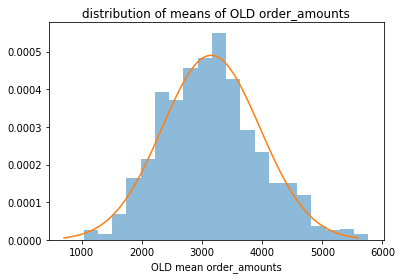

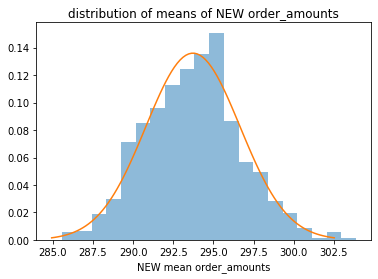

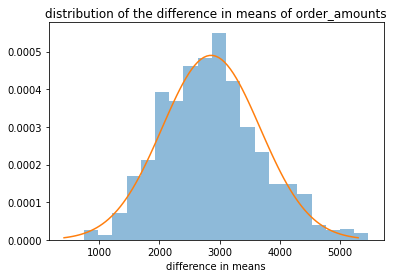

In [ ]:
n_OLD_bs= len(OLD_bs)
n_NEW_bs=len(NEW_bs)

#taking the means
mu_OLD_bs = np.mean(OLD_bs)
mu_NEW_bs = np.mean(NEW_bs)
sal_bs_diff= np.array(OLD_bs) - np.array(NEW_bs)
mu_sal_bs_diff = mu_OLD_bs - mu_NEW_bs

#taking the spread, note: spread of sum or difference should increase!
var_OLD_bs = np.var(OLD_bs)    
var_NEW_bs = np.var(NEW_bs)
var_sal_bs_diff = var_OLD_bs+ var_NEW_bs

plt.figure(1)
mu = mu_OLD_bs
sigma = math.sqrt(var_OLD_bs)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(OLD_bs, bins = b,label = 'OLD Distribution', alpha = 0.5, density=True)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.xlabel('OLD mean order_amounts')
plt.title('distribution of means of OLD order_amounts')
plt.show()

plt.figure(2)
mu = mu_NEW_bs
sigma = math.sqrt(var_NEW_bs)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(NEW_bs, bins = b,label = 'NEW Distribution', alpha = 0.5, density=True)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.xlabel('NEW mean order_amounts')
plt.title('distribution of means of NEW order_amounts')
plt.show()

plt.figure(3)
mu = mu_sal_bs_diff
sigma = math.sqrt(var_sal_bs_diff)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.hist(sal_bs_diff, bins = b,label = 'NEW Distribution', alpha = 0.5, density=True)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.xlabel('difference in means')
plt.title('distribution of the difference in means of order_amounts')
plt.show()

**Visually Normality Check's Out**

##### Hypothesis Test

Thanks to bootstrapping and Central Limit Theorem, we now have normally distributed bootstrapped datasets that we can apply our favourite test statistic to.


For our T-test:

$H_0$: No Significant difference between the means of the Unfiltered (OLD) vs filtered (NEW) distributions.<br>

$H_a$: There is a difference between the means of the Unfiltered (OLD) vs filtered (NEW) distributions.<br>

$\alpha$ = 5% (generic setting used)

In [ ]:
#import scipy.stats
#from scipy.stats import ttest_ind
#ttest, p_value = scipy.stats.ttest_ind(OLD_bs, NEW_bs, equal_var=False)
#print(ttest, p_value)

import scipy.stats
from scipy.stats import ttest_ind

ttest, pval= stats.ttest_ind(NEW_bs, OLD_bs, equal_var=False)

if pval < 0.05:
    print('P-value:', pval," < 0.05. \nReject null hypothesis, There is a difference between the means and it is statistically significant!",'\nT-value=', ttest)
else:
    print('P-value:', pval," > 0.05. \nFail to reject null hypothesis, difference between the means is not significant",'\nT-value=', ttest)

P-value: 0.0  < 0.05. 
Reject null hypothesis, There is a difference between the means and it is statistically significant! 
T-value= -110.91376717210534


Conclusion:

It was evident from when plotting the bootstrapped histograms that there is a large and possibly statistically significant difference between the old and new (filtered) distributions. This was further validated by the hypothesis test.

### c. What metric would you report for this dataset? d. What is its value?
 

- If the addition of bias via the removal of points deemed outliers is acceptable for our application. Then we would go with the mean or median of our Filtered-In Dataset as derived and explained in the previous section. Because the distribution is skewed multimodal, I would take the median of **$280**


In [ ]:
filtered_in.order_amount.describe()

count    4859.000000
mean      293.715374
std       144.453395
min        90.000000
25%       162.000000
50%       280.000000
75%       380.000000
max       730.000000
Name: order_amount, dtype: float64

**Otherwise:**
- Simply use the median of the initial unaltered dataset (it is only 4$ higher than the median of the filtered data! )

  - **$284**

## **Question** 2: 
For this question you’ll need to use SQL. Follow this link: https://www.w3schools.com/SQL/TRYSQL.ASP?FILENAME=TRYSQL_SELECT_ALL to access the data set required for the challenge. Please use queries to answer the following questions. Paste your queries along with your final numerical answers below.

>a. How many orders were shipped by Speedy Express in total?

>b. What is the last name of the employee with the most orders?

>c. What product was ordered the most by customers in Germany?

### a. How many orders were shipped by Speedy Express in total?


```
SELECT COUNT(*) AS number_of_orders
FROM Orders JONEW Shippers ON Shippers.ShipperID = Orders.ShipperID
WHERE Shippers.ShipperName = 'Speedy Express'
```
|	number_of_orders|
|-|
|54|

### b. What is the last name of the employee with the most orders?



```
SELECT Employees.LastName, COUNT(*) AS number_of_orders
FROM Employees JONEW Orders ON Employees.EmployeeID = Orders.EmployeeID
GROUP BY Employees.LastName 
ORDER BY number_of_orders DESC
LIMIT 1;
```
|LastName |	number_of_orders|
|-|-|
|Peacock	|40|

### c. What product was ordered the most by customers in Germany?


```
SELECT Products.productName, SUM(OrderDetails.Quantity) AS number_of_orders
FROM OrderDetails JONEW Orders ON Orders.OrderID = OrderDetails.orderID
JONEW Products ON OrderDetails.ProductID = Products.ProductID
JONEW Customers ON Customers.CustomerID = Orders.CustomerID
WHERE Customers.Country = 'Germany'
GROUP BY Products.productID
ORDER BY number_of_orders DESC
LIMIT 1;
```

|ProductName|number_of_orders |
|-|-|
|Boston Crab Meat| 160|

Incase this was also needed, ProductID was 40